In [221]:
import os
from pathlib import PurePath, Path
import ssl

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### SSL Certificate for downloading


In [222]:
ssl._create_default_https_context = ssl._create_unverified_context

### Downloading and extracting images dataset


In [223]:
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)
print(data_dir)

/Users/igor/.keras/datasets/cats_and_dogs_filtered.zip


### Dataset labels


In [224]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


### Dataset path


In [225]:
data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered_merged')
data_dir = pathlib.Path(data_dir)
print(data_dir)

/Users/igor/.keras/datasets/cats_and_dogs_filtered_merged


### Creating training and validation datasets


In [226]:
img_height,img_width=180,180
batch_size=32
seed=1337
validation_split=0.2

print('=====Testing=====')

train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="training",
  validation_split=validation_split,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


print('\r\n=====Validation=====')

val = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="validation",
  validation_split=validation_split,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

=====Testing=====
Found 3000 files belonging to 2 classes.
Using 2400 files for training.

=====Validation=====
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


### Data view


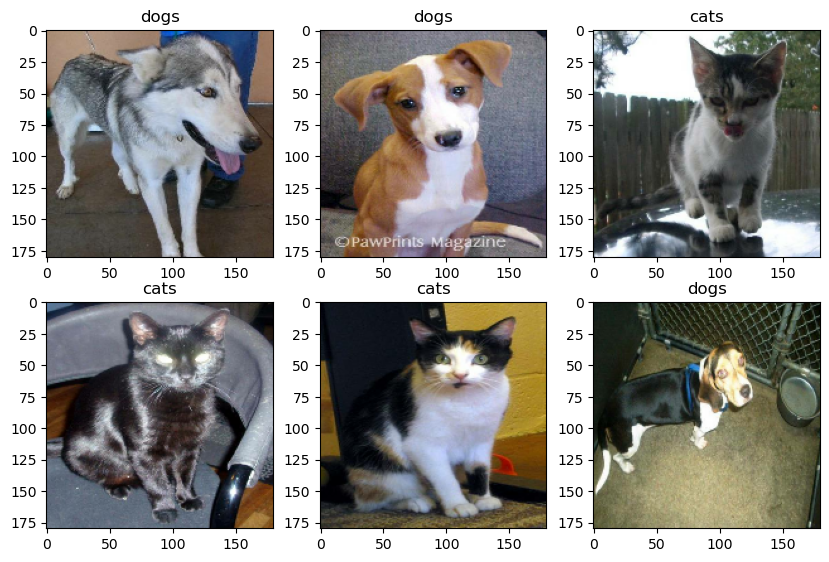

In [227]:
plt.figure(figsize=(10, 10))

# take 1 batch
for images, labels in train.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

### Adjusting Resnet50


In [228]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling='avg',
    weights='imagenet',
    classes=2)


for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)

In [229]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='sigmoid'))

In [230]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                                 
 dense_17 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


### Training


In [231]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model = resnet_model.fit(train, validation_data=val, epochs=5)

Epoch 1/5


2022-11-14 20:45:20.271556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9371

2022-11-14 20:45:28.862950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 12s 142ms/step - loss: 0.2304 - accuracy: 0.9371 - val_loss: 0.1371 - val_accuracy: 0.9500
Epoch 2/5
75/75 [==============================] - 9s 125ms/step - loss: 0.0603 - accuracy: 0.9737 - val_loss: 0.1109 - val_accuracy: 0.9600
Epoch 3/5
75/75 [==============================] - 9s 125ms/step - loss: 0.0299 - accuracy: 0.9888 - val_loss: 0.1137 - val_accuracy: 0.9617
Epoch 4/5
75/75 [==============================] - 9s 126ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.1176 - val_accuracy: 0.9683
Epoch 5/5
75/75 [==============================] - 10s 126ms/step - loss: 0.0046 - accuracy: 0.9996 - val_loss: 0.1252 - val_accuracy: 0.9633


### Accuracy and Loss fn on training and validation datasets


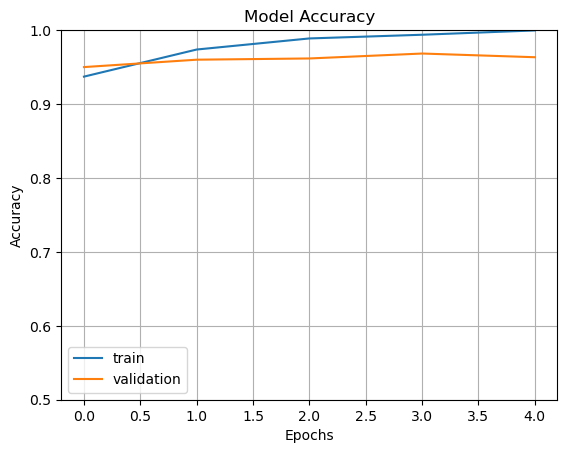

In [232]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0.5,ymax=1)
plt.grid()

plt.show()

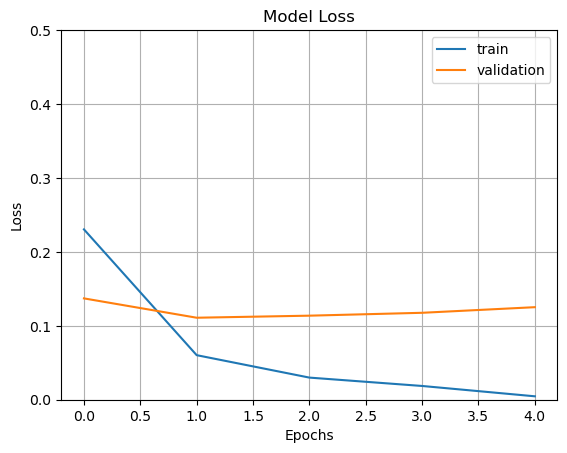

In [233]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=0.5)
plt.grid()

plt.show()

### Testing model on custom pictures


In [234]:
test_data_dir=Path(Path().parent.absolute(), 'example_pictures')
example_pictures = sorted(list(test_data_dir.glob('*.jpg')))

In [ ]:
index = 0

#load image
image=cv2.imread(str(example_pictures[index]))
#resize image
image_resized= cv2.resize(image, (img_height,img_width))
#expand dimensions
expanded_image=np.expand_dims(image_resized,axis=0)

pred=np.squeeze(resnet_model.predict(expanded_image))
confidence = pred[np.argmax(pred)] * 100
output_class=class_names[np.argmax(pred)]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'{output_class} {str(round(confidence, 2))}%');
plt.axis("off")